# Convolutional Variational Autoencoder - Image Inpainting

## Import TensorFlow and other libraries

In [80]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from PIL import Image

from IPython import display
from random import randint
from math import sqrt

## Load the Data
Each face image is originally a vector of 90*150 integers, each of which is between 0-255 and represents the intensity of a pixel. We model each pixel with a Bernoulli distribution in our model, and we statically binarize the dataset.

In [2]:
def load_image( infilename ) :
    img = Image.open(infilename)
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

In [50]:
train_images = np.empty([26000,150,90])
i = 0
for file in os.listdir("Test-Data/y"): #rename later
    img = load_image("Test-Data/y/"+ file)
    train_images[i] = img
    i += 1 

In [51]:
test_images = np.empty([233,150,90])
i = 0
for file in os.listdir("Cropped-Faces/test-images"):
    img = load_image("Cropped-Faces/test-images/"+ file)
    test_images[i] = img
    i += 1 

In [52]:
train_images = train_images.reshape(train_images.shape[0], 150, 90, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 150, 90, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

In [54]:
TRAIN_BUF = 26000
BATCH_SIZE = 100

TEST_BUF = 5000

## Use *tf.data* to create batches and shuffle the dataset

In [55]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

## Wire up the generative and inference network with *tf.keras.Sequential*

In our VAE example, we use two small ConvNets for the generative and inference network. Since these neural nets are small, we use `tf.keras.Sequential` to simplify our code. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [89]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim, inference_net=None, generative_net=None):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    if inference_net:
        self.inference_net = inference_net
    else:
        self.inference_net = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(150, 90, 1)),
              tf.keras.layers.Conv2D(
                  filters=32, kernel_size=9, strides=(2, 2), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=9, strides=(2, 2), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=9, strides=(2, 2), activation='relu'),
              tf.keras.layers.Flatten(),
              # No activation
              tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
        )
    if generative_net:
        self.generative_net = generative_net
    else:
        self.generative_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
              tf.keras.layers.Conv2DTranspose(
                  filters=64,
                  kernel_size=9,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=64,
                  kernel_size=9,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=32,
                  kernel_size=9,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
            ]
        )
        

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [90]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x, masked_x):
  mean, logvar = model.encode(masked_x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x) #output of model, correct output
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, masked_x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, masked_x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

## Generate Images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [66]:
epochs = 5
latent_dim = 69
num_examples_to_generate = 16

In [67]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

In [68]:
model = CVAE(latent_dim)

In [84]:
def erase_line(img, n, m):
    x1,y1 = randint(0,n-1),randint(0,m-1)
    x2,y2 = randint(0,n-1),randint(0,m-1)
    a = y1 - y2
    b = x2 - x1
    c = x1 * y2 - x2 * y1
    ret = img.copy()
    for x0 in range(min(x1, x2), max(x1, x2)):
        for y0 in range(min(y1,y2), max(y1, y2)):
            d = abs(a * x0 + b * y0 + c)/sqrt(a*a+b*b)
            if d < 5:
                ret[x0][y0]=1
    return ret

In [85]:
def erase_box(img, n, m):
    x1,y1 = randint(50,n-31),randint(50,m-31)
    x2,y2 = x1+30,y1+30
    ret = img.copy()
    for x0 in range(min(x1, x2), max(x1, x2)):
        for y0 in range(min(y1,y2), max(y1, y2)):
            ret[x0][y0]=1
    return ret

In [71]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [91]:
#generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):  
  start_time = time.time()
  for train_x in train_dataset:
    masked_x = tf.convert_to_tensor(erase_line(train_x.numpy(), train_x.shape[0], train_x.shape[1]), dtype=tf.float32)
    compute_apply_gradients(model, train_x, masked_x, optimizer) #add another parameter (lineyInput)
    
  #for train_x in train_dataset:
  #  masked_x = erase_box(train_x, train_x.shape[0], train_x.shape[1])
  #  compute_apply_gradients(model, train_x, masked_x, optimizer) #add another parameter (lineyInput)
    
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      masked_x = tf.convert_to_tensor(erase_line(test_x.numpy(), test_x.shape[0], test_x.shape[1]), dtype=tf.float32)
      loss(compute_loss(model, test_x, masked_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    #generate_and_save_images(model, epoch, random_vector_for_generation)

ValueError: in converted code:

    <ipython-input-82-8d39553586e5>:24 compute_apply_gradients  *
        loss = compute_loss(model, x, masked_x)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/eager/def_function.py:568 __call__
        result = self._call(*args, **kwds)
    <ipython-input-82-8d39553586e5>:15 compute_loss  *
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x) #output of model, correct output
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:239 sigmoid_cross_entropy_with_logits_v2
        logits=logits, labels=labels, name=name)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:170 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((100, 56, 56, 1) vs (100, 150, 90, 1))


In [21]:
model.inference_net.save_weights("cvae-inference-weights")
model.generative_net.save_weights("cvae-generative-weights")

In [22]:
inf_model = model.inference_net
inf_model.load_weights("cvae-inference-weights")

In [23]:
gen_model = model.generative_net
gen_model.load_weights("cvae-generative-weights")

In [24]:
#model = CVAE(tf.keras.models.load_model("cvae-inference-model.h5"), tf.keras.models.load_model("cvae-generative-model.h5"))

In [25]:
model = CVAE(latent_dim, inf_model, gen_model)

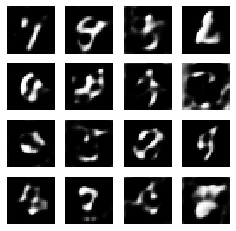

In [26]:
generate_and_save_images(model, 0, random_vector_for_generation)

### Display an image using the epoch number

In [27]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

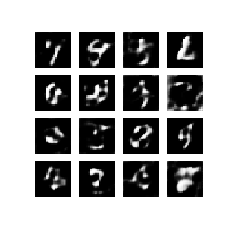

In [28]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

### Generate a GIF of all the saved images.

In [29]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [30]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)